Let's start with using the open sourced OPENAI CLIP model

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bzchp_gr
  Running command git clone --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bzchp_gr
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [1]:
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
from open_clip import create_model_from_pretrained


import cv2
import numpy as np
    
device = "cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)
clip_inres = clipmodel.visual.input_resolution
clip_ksize = clipmodel.visual.conv1.kernel_size

print("[clip resolution]:", clip_inres)
print("[clip kernel size]:", clip_ksize)

[clip resolution]: 224
[clip kernel size]: (16, 16)


In [2]:
_transform = Compose([
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
def imgprocess(img, patch_size=[16, 16], scale_factor=1):
    w, h = img.size
    ph, pw = patch_size
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)

def visualize(map, raw_image, resize):
    image = np.asarray(raw_image.copy())
    map = resize(map.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((map*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

In [3]:
def attention_layer(q, k, v, num_heads=1):
    "Compute 'Scaled Dot Product Attention'"
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    q = q * scaling
    
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    attn_output_heads = torch.bmm(attn_output_weights, v)
    assert list(attn_output_heads.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output_heads.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights
    
def clip_encode_dense(x,n):
    vision_width = clipmodel.visual.transformer.width
    vision_heads = vision_width // 64
    print("[vision_width and vision_heads]:", vision_width, vision_heads)
    
    # modified from CLIP
    x = x.half()
    x = clipmodel.visual.conv1(x)  
    feah, feaw = x.shape[-2:]

    x = x.reshape(x.shape[0], x.shape[1], -1) 
    x = x.permute(0, 2, 1) 
    class_embedding = clipmodel.visual.class_embedding.to(x.dtype)
    x = torch.cat([class_embedding + torch.zeros(x.shape[0], 1, x.shape[-1]).to(x), x], dim=1)

    ## scale position embedding as the image w-h ratio
    pos_embedding = clipmodel.visual.positional_embedding.to(x.dtype)
    tok_pos, img_pos = pos_embedding[:1, :], pos_embedding[1:, :]
    pos_h = clip_inres // clip_ksize[0]
    pos_w = clip_inres // clip_ksize[1]
    assert img_pos.size(0) == (pos_h * pos_w), f"the size of pos_embedding ({img_pos.size(0)}) does not match resolution shape pos_h ({pos_h}) * pos_w ({pos_w})"
    img_pos = img_pos.reshape(1, pos_h, pos_w, img_pos.shape[1]).permute(0, 3, 1, 2)
    print("[POS shape]:", img_pos.shape, (feah, feaw))
    img_pos = torch.nn.functional.interpolate(img_pos, size=(feah, feaw), mode='bicubic', align_corners=False)
    img_pos = img_pos.reshape(1, img_pos.shape[1], -1).permute(0, 2, 1)
    pos_embedding = torch.cat((tok_pos[None, ...], img_pos), dim=1)
    x = x + pos_embedding
    x = clipmodel.visual.ln_pre(x)
    
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = torch.nn.Sequential(*clipmodel.visual.transformer.resblocks[:-n])(x)

    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []
    for TR in clipmodel.visual.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear    
        q, k, v = linear(x, TR.attn.in_proj_weight, TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(q, k, v, 1)  # vision_heads=1
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)
        
        x_after_attn = linear(attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)       
        x = x_after_attn + x_in
        x = x + TR.mlp(TR.ln_2(x))

    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clipmodel.visual.ln_post(x)
    x = x @ clipmodel.visual.proj
    return x, x_in, vs, qs, ks, attns, atten_outs, (feah, feaw)

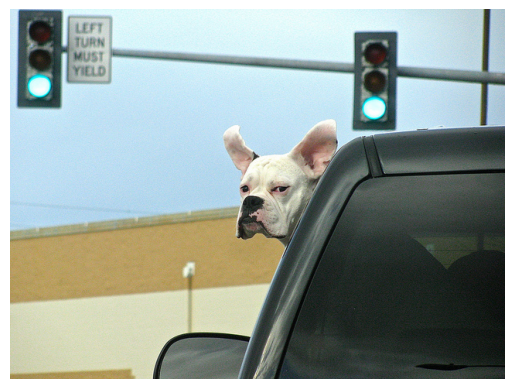

In [4]:
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
texts = ["dog", "car", "traffic lights", "a dog in a car waiting for traffic lights"] 

# url = "http://l7.alamy.com/zooms/1e7674256f464050bf142a5d21407ede/single-cowboy-guiding-a-line-of-horses-through-the-desert-bnh6m3.jpg"
# img = Image.open(urlopen(url))
# texts = ["cowboy", "horse", "desert", "single cowboy guiding a line of horses through the desert"]

plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
# preprocess image and text
img_preprocessed = preprocess(img).cuda().unsqueeze(0)
text_processed = clip.tokenize(texts).cuda()
# extract text featrue
text_embedding = clipmodel.encode_text(text_processed)
text_embedding = F.normalize(text_embedding, dim=-1)
print("[text embedding]:", text_embedding.shape)

ori_img_embedding = clipmodel.encode_image(img_preprocessed)
ori_img_embedding = F.normalize(ori_img_embedding, dim=-1)
print("[image embedding]:", ori_img_embedding.shape)

cosine = (ori_img_embedding @ text_embedding.T)
print("[cosine]:", cosine)

[text embedding]: torch.Size([4, 512])
[image embedding]: torch.Size([1, 512])
[cosine]: tensor([[0.2678, 0.2377, 0.2605, 0.3503]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward0>)


In [6]:
img_preprocessed_k = imgprocess(img).cuda().unsqueeze(0)
#
# x, vs, qs, ks, attns, atten_outs, (feah, feaw)
outputs, last_feat, vs, qs, ks, attns, atten_outs, map_size = clip_encode_dense(img_preprocessed_k, n=1)
img_embedding = F.normalize(outputs[:,0], dim=-1)
print("[image embedding]:", img_embedding.shape)
cosine = (img_embedding @ text_embedding.T)[0]
print("cosine:", cosine)

# similarity between text prompt and patch features
p_final = F.normalize(outputs[:,1:], dim=-1)
cosine_p = (p_final @ text_embedding.T)[0].transpose(1,0).reshape(-1, *map_size)
print("[position similarity (cosine p)]:", cosine_p.shape)

[vision_width and vision_heads]: 768 12
[POS shape]: torch.Size([1, 768, 14, 14]) (30, 40)
[image embedding]: torch.Size([1, 512])
cosine: tensor([0.1899, 0.2028, 0.2117, 0.1715], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
[position similarity (cosine p)]: torch.Size([4, 30, 40])


# Generate Grad-ECLIP map

In [7]:
# generate ODAM map

def sim_qk(q, k):
    q_cls = F.normalize(q[:1,0,:], dim=-1) 
    k_patch = F.normalize(k[1:,0,:], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1) 
    cosine_qk_max = cosine_qk.max(dim=-1, keepdim=True)[0]
    cosine_qk_min = cosine_qk.min(dim=-1, keepdim=True)[0]
    cosine_qk = (cosine_qk-cosine_qk_min) / (cosine_qk_max-cosine_qk_min)
    return cosine_qk

def grad_eclip(c, qs, ks, vs, attn_outputs, map_size):
    ## gradient on last attention output
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]

        grad_cls = grad[:1,0,:]
        v_patch = v[1:,0,:]
        cosine_qk = sim_qk(q, k).reshape(-1)
        tmp_maps.append((grad_cls * v_patch * cosine_qk[:,None]).sum(-1)) 

    emap = F.relu_(torch.stack(tmp_maps, dim=0)).sum(0)
    return emap.reshape(*map_size)

def self_attn(attns, map_size):
    attn_patch = attns[-1][0,:1,1:].reshape(*map_size)
    print("[attn of cls token on lastv]:", attn_patch.shape)
    return attn_patch

def grad_cam(c, feat, map_size):
    ## GRAD-CAM: use the feature outputs of the final attention layer
    grad = torch.autograd.grad(
        c,
        feat,
        retain_graph=True)[0]
    grad_weight = grad.mean(0, keepdim=True)
    grad_cam = F.relu_((grad_weight * feat).sum(-1))
    grad_cam = grad_cam[1:].reshape(*map_size)
    return  grad_cam   


['dog', 'car', 'traffic lights', 'a dog in a car waiting for traffic lights']


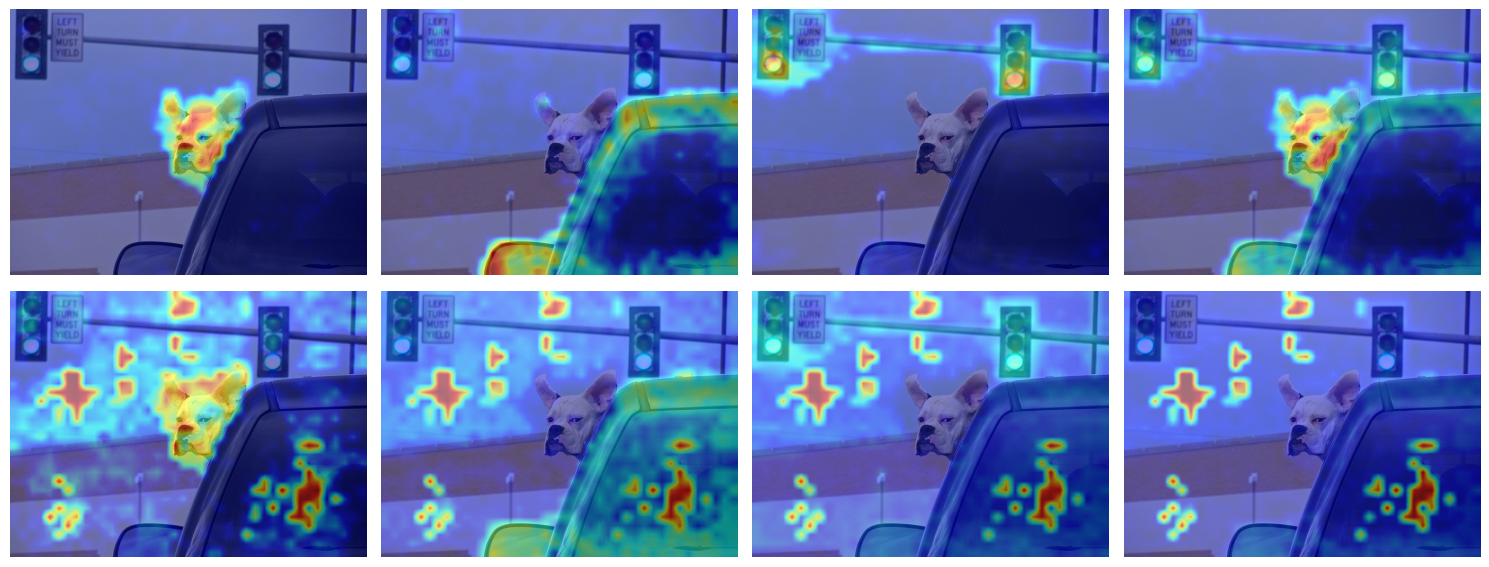

In [8]:
grad_emaps = []
grad_cams = []
for i, c in enumerate(cosine):
    grad_emaps.append(grad_eclip(c, qs, ks, vs, atten_outs, map_size))
    grad_cams.append(grad_cam(c, last_feat, map_size))

print(texts)
h, w = img.size
resize = T.Resize((w,h))
fig, axs = plt.subplots(ncols=len(cosine), nrows=2, figsize=(15, 6))
for i, ax in enumerate(axs.T):
    tmp = grad_emaps[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax[0].axis('off')
    ax[0].imshow(c_ret)

    tmp = grad_cams[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax[1].axis('off')
    ax[1].imshow(c_ret)

fig.tight_layout()